# A3: Frequency Domain Filtering
# Image Processing
**Cade Parkison**

---

**Jupyter Notebook Settings:**

Make the output cells to use compact formatting:

In [3]:
format compact

---

**Test Image**

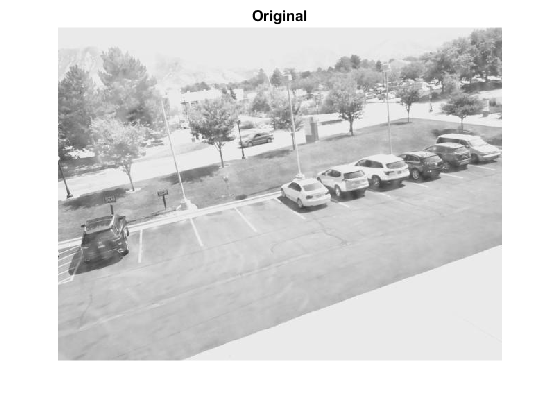

In [2]:
im = rgb2gray(imread('im2.jpg'));
imshow(im); title('Original');

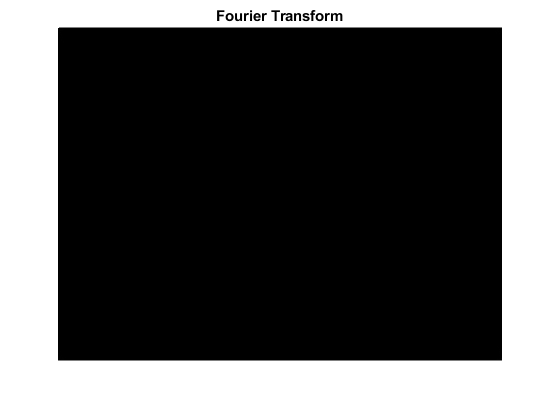

In [2]:
% Get Fourier Transform
F = fft2(im);
S = abs(F);

imshow(S, []); title('Fourier Transform');

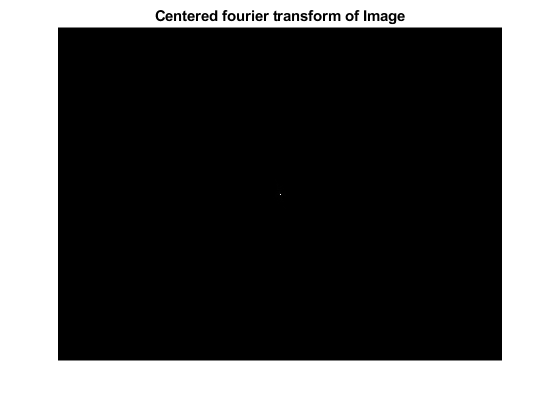

In [3]:
%get the centered spectrum
Fsh = fftshift(F);
imshow(abs(Fsh),[]);title('Centered fourier transform of Image')

In [8]:
a = [];
for i=1:3
    a = [i, a];
end

In [9]:
a

a =
     3     2     1



In [12]:
%%python
print("hello from python")

hello from python


In [13]:
disp("hello from matlab")

hello from matlab



In [11]:
help sin

 SIN    Sine of argument in radians.
    SIN(X) is the sine of the elements of X.
 
    See also ASIN, SIND.

    Reference page in Doc Center
       doc sin

    Other functions named sin

       sym/sin




In [14]:
?sin

 SIN    Sine of argument in radians.
    SIN(X) is the sine of the elements of X.
 
    See also ASIN, SIND.

    Reference page in Doc Center
       doc sin

    Other functions named sin

       sym/sin



In [15]:
% doc prompts a seperate window
doc sin

In [16]:
tx = linspace (-8, 8, 41);
ty = tx;
[xx, yy] = meshgrid (tx, ty);
r = sqrt (xx .^ 2 + yy .^ 2) + eps;
tz = sin (r) ./ r;

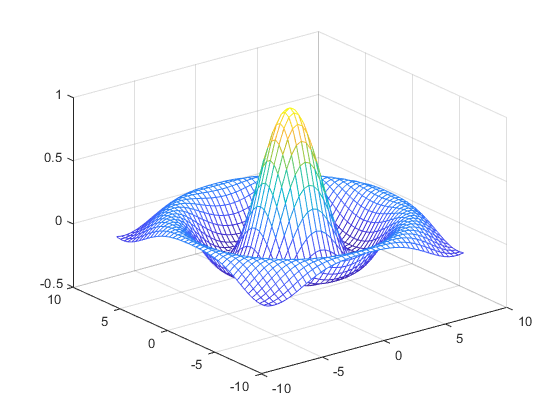

In [19]:
%plot inline
mesh(tx, ty, tz);

In [20]:
%plot native
mesh(tx, ty, tz);

In [21]:
?%plot

%plot [options] backend - configure plotting for the session.

This line magic will configure the plot settings for this
language.

Examples:
    %plot qt --format=png
    %plot inline -w 640

Note: not all languages may support the %plot magic, and not all
options may be supported.

Options:
-------
-h --height    Plot height in pixels
-w --width     Plot width in pixels
-r --resolution Resolution in pixels per inch
-b --backend   Backend selection [default: inline]
-f --format    Plot format (png, svg or jpg).
-s --size      Pixel size of plots, "width,height"

---

## Problem 1

Develop a texture feature analysis tool based on the 2D FFT power spectrum. For every 5x5 region in the image, compute the 2D FFT, compute the power spectrum, and use that as a 25-element feature vector. Produce a texture feature array, M*N by 25, and then use kmeans as in A2 to explore the usefulness of this for semantic region analysis (based on texture) in our videos.


#### Functions

In [ ]:
%%file CS6640_FFT_texture.m

function  T = CS6640_FFT_texture(im)
% CS6640_FFT_texture - compute FFT texture parameters
% On input:
%     im (MxN array): input image
% On output:
%     T (M*Nx25 array): texture parameters
%       each texture parameter is a column vector in T
% Call:
%     T = CS6640_FFT_texture(im);
% Author:
%     Cade Parkison
%     UU
%     Fall 2018
%

[M,N] = size(im);
T = zeros(M,N, 25);
window = 5;

for i=3:M-2
    for j=3:N-2
        % get 5x5 window surrounding (i,j)
        w = im(i-2:i+2, j-2:j+2);
        % take FFT of window
        F = fft2(w);
        % get power spectrum of F 
        ps = F.*conj(F);
        % Fill in T at (x,y,t) where t is the texture parameter 1:25
        T(i,j,1:25) = ps(:);
    end
end

% reshape T to (480*640 x 25)
T = reshape(T, M*N, 25);

---
#### Testing

In [ ]:
clear all;close all;clc

In [ ]:
im = rgb2gray(imread('im2.jpg'));
%figure(1);imshow(im); title('Original');

T = CS6640_FFT_texture(im);

% K-means on T 
[cidx,ctrs] = kmeans(T,9);
figure(1);combo(mat2gray(im),(reshape(cidx==1,480,640)));title('K=1');
figure(2);combo(mat2gray(im),(reshape(cidx==2,480,640)));title('K=2');
figure(3);combo(mat2gray(im),(reshape(cidx==3,480,640)));title('K=3');
figure(4);combo(mat2gray(im),(reshape(cidx==4,480,640)));title('K=4');
figure(5);combo(mat2gray(im),(reshape(cidx==5,480,640)));title('K=5');
figure(6);combo(mat2gray(im),(reshape(cidx==6,480,640)));title('K=6');
figure(7);combo(mat2gray(im),(reshape(cidx==7,480,640)));title('K=7');
figure(8);combo(mat2gray(im),(reshape(cidx==8,480,640)));title('K=8');
figure(9);combo(mat2gray(im),(reshape(cidx==9,480,640)));title('K=9');


%combo(mat2gray(rgb2gray(im)),(reshape(cidx==1|cidx==4,480,640)));
%combo(mat2gray(rgb2gray(im)),(reshape(cidx==1|cidx==4,480,640)));
%combo(mat2gray(rgb2gray(im)),(reshape(cidx==1|cidx==4,480,640)));
%combo(mat2gray(rgb2gray(im)),(reshape(cidx==1|cidx==4,480,640)));

---
## Problem 2

Develop another FFT texture analysis approach based on radial segments
of the power spectrum. A radial feature is defined by a radius pair:

$$ f_{r_1,r_2} = \sum \sum {| F(u, v) |}^2 $$

where $ {r_1}^2 ≤ u^2 + v^2 < {r_2}^2 $. 
Suppose there are 10 such pairs, specified by 10 radii; i.e.:
$ R = \{0, r_1, r_2, . . . , r_10\} $ Produce a texture feature array, M*N by 10, and then use kmeans
as in A2 to explore the usefulness of this for semantic region analysis (based on texture) in
our videos.

#### Functions

In [147]:
%%file CS6640_rings.m

function rings = CS6640_rings
%  CS6640_rings - computes cell array of linear indices of each ring to be used with the FFT_radial function
%
% On output:
%     rings (cell array) - Structure holding the (x,y) index pairs of each ring
% Call:
%     rings = CS6640_rings;
% Author:
%     Cade Parkison
%     UU
%     Fall 2018
%

rings = {};
% center
xc = 10; yc = 10;

for r=0:9;
    ring = [];
    rmin = r;
    rmax = r+1;
    for i=1:19
        for j=1:19
            % L-p norm from pixel to center of window
            p = 10;
            x = (xc-i)^p + (yc-j)^p;
            d = nthroot(x, p);
            if d >= rmin
                if d < rmax
                    % find linear index for corresponding (i,j) in the 19x19 matrix
                    ind = sub2ind([19,19], i, j);
                    ring = [ind; ring];
                end
            end
        end
    end
    rings{r+1} = ring; 
end
end

Created file 'C:\Users\cadep\School\CS_6640\A3\CS6640_rings.m'.


In [32]:
%%file CS6640_FFT_radial.m

function  T = CS6640_FFT_radial(im)
%  CS6640_FFT_radial - compute FFT radial texture parameters
% On input:
%     im (MxN array): input image
% On output:
%     T (M*Nx10 array): texture parameters
%       each texture parameter is a column vector in T
% Call:
%     T = CS6640_FFT_radial(im);
% Author:
%     Cade Parkison
%     UU
%     Fall 2018
%

[M,N] = size(im);
T = zeros(M,N, 10);

% Cell array of length 10, each element containing list of (x,y) indices for each annulus
rings = CS6640_rings;

for i=10:M-9
    for j=10:N-9
        
        % get 19x19 window surrounding (i,j)
        w = im(i-9:i+9, j-9:j+9);
        % take FFT of window
        F = fft2(w);
        % get power spectrum of F 
        ps = F.*conj(F);
        % Compute Radial segments of ps for each annulus
        for r=1:10
            ps_r = ps(rings{r});
            % sum square of ps_r
            s = sum(ps_r.^2);
        end
        
        end
        % Fill in T at (x,y,t) where t is the texture parameter 1:10
        T(i,j,1:10) = 
    end
end

% reshape T to (480*640 x 10)
T = reshape(T, M*N, 10);

Created file 'C:\Users\cadep\School\CS_6640\A3\CS6640_FFT_radial.m'.


---
#### Testing

In [149]:
clear all;close all;clc;

In [154]:
rings = CS6640_rings;
rings{1}

ans =
   181



In [160]:
a = rings{2}

a =
   201
   182
   163
   200
   162
   199
   180
   161



In [152]:
r = rand(19);
size(r)

ans =
    19    19



In [163]:
r(181)
r(201)
r(163)

ans =
    0.0442
ans =
    0.3900
ans =
    0.7295



In [184]:
a = r(rings{2})
b = a.^2

a =
    0.3900
    0.5573
    0.7295
    0.1375
    0.7043
    0.8944
    0.0991
    0.3782
b =
    0.1521
    0.3106
    0.5322
    0.0189
    0.4961
    0.8000
    0.0098
    0.1430



In [185]:
sum(r(rings{2}).^2)

ans =
    2.4628



In [176]:
size(rings{3})

ans =
    16     1



In [140]:
?ind2sub

 IND2SUB Multiple subscripts from linear index.
    IND2SUB is used to determine the equivalent subscript values
    corresponding to a given single index into an array.
 
    [I,J] = IND2SUB(SIZ,IND) returns the arrays I and J containing the
    equivalent row and column subscripts corresponding to the index
    matrix IND for a matrix of size SIZ.  
    For matrices, [I,J] = IND2SUB(SIZE(A),FIND(A>5)) returns the same
    values as [I,J] = FIND(A>5).
 
    [I1,I2,I3,...,In] = IND2SUB(SIZ,IND) returns N subscript arrays
    I1,I2,..,In containing the equivalent N-D array subscripts
    equivalent to IND for an array of size SIZ.
 
    Class support for input IND:
       float: double, single
       integer: uint8, int8, uint16, int16, uint32, int32, uint64, int64
 
    See also SUB2IND, FIND.

    Reference page in Doc Center
       doc ind2sub

    Other functions named ind2sub

       tall/ind2sub



---
## Problem 3

Develop another FFT texture analysis approach based on angular segments of the power spectrum. An angular feature is defined by a angle pair:

$$ f_{θ_1,θ_2} = \sum \sum {| F(u, v) |}^2 $$

where $θ_1 ≤ tan^{−1}(v, u) < θ_2$, and $u^2 + v^2 < L^2$
for some appropriate L. Suppose there
are 8 such segments, specified by 9 angles; i.e.: $A = \{0, ∆, 2∆, . . . , 8∆\}$, where $∆ = 45$ degrees. Produce a texture feature array, M*N by 8 (where these cover ∆θ between the following angles: $\{0, 45, 90, 135, 180, 225, 270, 315, 360\}$, and then use kmeans as in A2 to explore the usefulness of this for semantic region analysis (based on texture) in our videos.

#### Functions

In [33]:
%%file CS6640_FFT_angular.m

function  T = CS6640_FFT_angular(im)
%  CS6640_FFT_angular - compute FFT angular texture parameters
% On input:
%     im (MxN array): input image
% On output:
%     T (M*Nx8 array): texture parameters
%       each texture parameter is a column vector in T
% Call:
%     T = CS6640_FFT_angular(im);
% Author:
%     Cade Parkison
%     UU
%     Fall 2018
%

test

Created file 'C:\Users\cadep\School\CS_6640\A3\CS6640_FFT_angular.m'.


#### Testing

In [ ]:
clear all;close all;clc;

---
## Problem 4

Develop a Fourier shape descriptor function as described in the Zahn and Roskies paper (in ’lectures’ link from class web page, weeks5-6). I.e., given a shape as a set of connected boundary points:

$$ P = \{(x_i, y_i)\} $$

where i = 1 : N, of a shape (going clockwise), then the angle at each point is computed as:

$$ θ(t) = atan2(y(t + w) − y(t), x(t + w) − x(t)) $$

where w is a distance along the curve. θ is better produced by taking the previous direction,
and adding to it the amount of change in angle to get the current angle. Then produce the
function:

$$ φ(t) = (θ(t) − θ(0))mod2π $$

and

$$ ψ(a) = (φ(\frac{La}{2π}) + a)modπ $$

where ψ is computed over the interval [0, 2π]. Take the FFT of ψ, and if there are 2p Fourier coefficients, use the power of coefficients 2 to p as the shape descriptor (a vector).


#### Functions

In [ ]:
%%file CS6640_FFT_shape.m

function  X = CS6640_FFT_shape(Z,w)
%  CS6640_FFT_shape - compute Fourier shape descriptors for a curve
% On input:
%     Z (Nx2 array): input curve (should be closed)
%     w (int): distance along curve to determine angles
% On output:
%     X ((N/2-1)x1 vector): the Fourier coefficients for the curve
% Call:
%     X = CS6640_FFT_shape(curve,2);
% Author:
%     Cade Parkison
%     UU
%     Fall 2018
%



#### Testing

In [ ]:
clear all;close all;clc;